In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", 100 - percent_win(operations))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

In [2]:
def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    Viene verificata il superamento del massimo (long) o minimo (short) sul level
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    Viene verificata il raggiungimento del minimo (long) o massimo (short) sul level
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

In [3]:
def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

In [4]:
def apply_trading_system(imported_dataframe, bigpointvalue, tick, direction, order_type, 
                         enter_level, enter_rules, exit_rules):
    
    dataframe = imported_dataframe.copy()
    
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    
    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)                                                      
        
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')
        
    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.open.shift(-1) - dataframe.entry_price) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
            
    if direction == "short":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.entry_price - dataframe.open.shift(-1)) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

In [5]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

dataset = load_data_intraday("@GC_15min_Exchange.txt")

In [17]:
dataset.count()

open         302727
high         302727
low          302727
close        302727
volume       302727
dayofweek    302727
day          302727
month        302727
year         302727
dayofyear    302727
quarter      302727
hour         302727
minute       302727
hhv92        302727
llv92        302727
dtype: int64

In [18]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

dataset = load_data_intraday("@GC_15min_Exchange.txt")

dataset["hhv92"] = dataset.high.rolling(92).max()
dataset["llv92"] = dataset.low.rolling(92).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules = 1
enter_level = dataset.hhv92.shift(1)
exit_rules = dataset.hour == 22

trading_system = apply_trading_system(dataset, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                      enter_level, enter_rules, exit_rules)

In [93]:
def gsa(dataframe,step_IS,step_OOS):
    """
    Funzione che genera due dataframe ottenuti a partire dal dataframe totale
    altenando periodi di in sample ed out of sample in maniera simmetrica o asimmetrica
    ES: step_IS = 100, step_OOS = 100 barre -> IS 100 barre OOS 100 barre alternate
    ES: step_IS = 100, step_OOS = 50 barre -> IS 100 barre OOS 50 barre alternate
    """
    start = 0
    stop = start + step_IS
    while start < len(dataset):
        #print(start, stop, start + step_IS, stop + step_OOS)
        if start == 0:
            dataset_IS = dataframe.copy().iloc[start:stop]
            dataset_OOS = dataframe.copy().iloc[start + step_IS:stop + step_OOS]
        else:
            block_IS = dataframe.copy().iloc[start:stop]
            block_OOS = dataframe.copy().iloc[start + step_IS:stop + step_OOS]
            dataset_IS = pd.concat([dataset_IS,block_IS])
            dataset_OOS = pd.concat([dataset_OOS,block_OOS])
        #print(len(dataset_IS),len(dataset_OOS))
        start += step_IS + step_OOS
        stop = start + step_IS
    return dataset_IS, dataset_OOS

trading_system_IS, trading_system_OOS = gsa(trading_system,10000,10000)   

In [94]:
trading_system.open.count()

302727

In [95]:
trading_system_IS.open.count()

152727

In [96]:
trading_system_OOS.open.count()

150000

In [97]:
operations_IS = trading_system_IS.operations.dropna()
operations_OOS = trading_system_OOS.operations.dropna()

In [98]:
profit_IS = round(operations_IS.sum(),2)
profit_OOS = round(operations_OOS.sum(),2)
nop_IS = operation_number(operations_IS)
nop_OOS = operation_number(operations_OOS)
at_IS = avg_trade(operations_IS)
at_OOS = avg_trade(operations_OOS)
pf_IS = profit_factor(operations_IS)
pf_OOS = profit_factor(operations_OOS)
pw_IS = percent_win(operations_IS)
pw_OOS = percent_win(operations_OOS)
rrr_IS = reward_risk_ratio(operations_IS)
rrr_OOS = reward_risk_ratio(operations_OOS)
add_IS = avgdrawdown_nozero(operations_IS)
add_OOS = avgdrawdown_nozero(operations_OOS)
mdd_IS = max_draw_down(operations_IS)
mdd_OOS = max_draw_down(operations_OOS)

print("GSA In Sample vs Out of Sample Statistics - by Gandalf Project R&D")
print("")
print("Profit:                 [IS]", profit_IS, "[OOS]", profit_OOS, 
      "-> delta:", round((profit_OOS - profit_IS)/profit_OOS * 100), "%")
print("Operations:             [IS]", nop_IS, "[OOS]", nop_OOS, 
      "-> delta:", round((nop_OOS - nop_IS)/nop_OOS * 100), "%")
print("")
print("Average Trade:          [IS]", at_IS, "[OOS]", at_OOS, 
      "-> delta:", round((at_OOS - at_IS)/at_OOS * 100), "%")
print("Profit Factor:          [IS]", pf_IS, "[OOS]", pf_OOS, 
      "-> delta:", round((pf_OOS - pf_IS)/pf_OOS * 100), "%")
print("Percent Winning Trades: [IS]", pw_IS, "[OOS]", pw_OOS, 
      "-> delta:", round((pw_OOS - pw_IS)/pw_OOS * 100), "%")
print("Reward Risk Ratio:      [IS]", rrr_IS, "[OOS]", rrr_OOS, 
      "-> delta:", round((rrr_OOS - rrr_IS)/rrr_OOS * 100), "%")
print("Avg Open Draw Down:     [IS]", add_IS, "[OOS]", add_OOS, 
      "-> delta:", round((add_OOS - add_IS)/add_OOS * 100), "%")
print("Max Open Draw Down:     [IS]", mdd_IS, "[OOS]", mdd_OOS, 
      "-> delta:", round((mdd_OOS - mdd_IS)/mdd_OOS * 100), "%")

GSA In Sample vs Out of Sample Statistics - by Gandalf Project R&D

Profit:                 [IS] 112570.0 [OOS] 87800.0 -> delta: -28.0 %
Operations:             [IS] 1025 [OOS] 989 -> delta: -4.0 %

Average Trade:          [IS] 109.82 [OOS] 88.78 -> delta: -24.0 %
Profit Factor:          [IS] 1.38 [OOS] 1.28 -> delta: -8.0 %
Percent Winning Trades: [IS] 53.76 [OOS] 53.99 -> delta: 0.0 %
Reward Risk Ratio:      [IS] 1.19 [OOS] 1.09 -> delta: -9.0 %
Avg Open Draw Down:     [IS] -7782.37 [OOS] -4119.85 -> delta: -89.0 %
Max Open Draw Down:     [IS] -15790.0 [OOS] -10190.0 -> delta: -55.0 %


In [70]:
def plot_periods_old(step_IS,step_OOS):
    
    from pandas.plotting import register_matplotlib_converters
    
    plt.figure(figsize=(16, 8), dpi=300)
    plt.plot(trading_system.open_equity, color='green')

    # Generazione rettangoli In Sample
    start = 0
    stop = start + step_IS 
    while start < len(dataset):
        if start <= len(dataset):
            start_parsed = dataset.index[start]
        else:
            start_parsed = dataset.index[len(dataset) - 1]
        if stop <= len(dataset):
            end_parsed = dataset.index[stop]
        else:
            end_parsed = dataset.index[len(dataset) - 1]
        print("IS",start,start_parsed, stop, end_parsed)
        plt.axvline(x=start_parsed, color="yellow")
        plt.axvline(x=end_parsed, color="yellow")
        plt.axvspan(start_parsed, end_parsed, facecolor='yellow', alpha=0.4)
        start += step_IS + step_OOS
        stop = start + step_IS 
    print("")

    # Generazione rettangoli Out of Sample
    start = 0
    stop = start + step_IS 
    while start < len(dataset):
        if start + step_IS <= len(dataset):
            start_parsed = dataset.index[start + step_IS]
        else:
            start_parsed = dataset.index[len(dataset) - 1]
        if stop + step_OOS <= len(dataset):
            end_parsed = dataset.index[stop + step_OOS]
        else:
            end_parsed = dataset.index[len(dataset) - 1]
        print("OOS",start + step_OOS,start_parsed, stop + step_OOS, end_parsed)
        plt.axvline(x=start_parsed, color="lime")
        plt.axvline(x=end_parsed, color="lime")
        plt.axvspan(start_parsed, end_parsed, facecolor='lime', alpha=0.4)
        start += step_IS + step_OOS
        stop = start + step_IS            

    plt.xlabel("Time")
    plt.ylabel("Gain/Loss")
    plt.title("Equity Lines")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.show()

In Sample:
0 2007-01-02 18:45:00 10000 2007-06-07 19:15:00
20000 2007-11-08 06:45:00 30000 2008-04-16 09:00:00
40000 2008-09-16 03:15:00 50000 2009-02-18 08:15:00
60000 2009-07-22 10:45:00 70000 2009-12-22 16:15:00
80000 2010-05-27 22:15:00 90000 2010-10-28 05:30:00
100000 2011-03-31 14:30:00 110000 2011-09-01 16:15:00
120000 2012-02-06 10:30:00 130000 2012-07-09 22:45:00
140000 2012-12-10 05:45:00 150000 2013-05-17 05:45:00
160000 2013-10-21 22:45:00 170000 2014-03-27 05:45:00
180000 2014-08-28 10:45:00 190000 2015-02-01 23:15:00
200000 2015-07-06 07:00:00 210000 2015-12-04 11:15:00
220000 2016-05-10 15:30:00 230000 2016-10-10 21:30:00
240000 2017-03-15 05:45:00 250000 2017-08-16 06:45:00
260000 2018-01-18 15:00:00 270000 2018-06-21 18:30:00
280000 2018-11-21 19:30:00 290000 2019-04-29 12:30:00
300000 2019-09-30 02:30:00 310000 2019-11-08 17:00:00

Out of Sample:
10000 2007-06-07 19:15:00 20000 2007-11-08 06:45:00
30000 2008-04-16 09:00:00 40000 2008-09-16 03:15:00
50000 2009-02-18 08

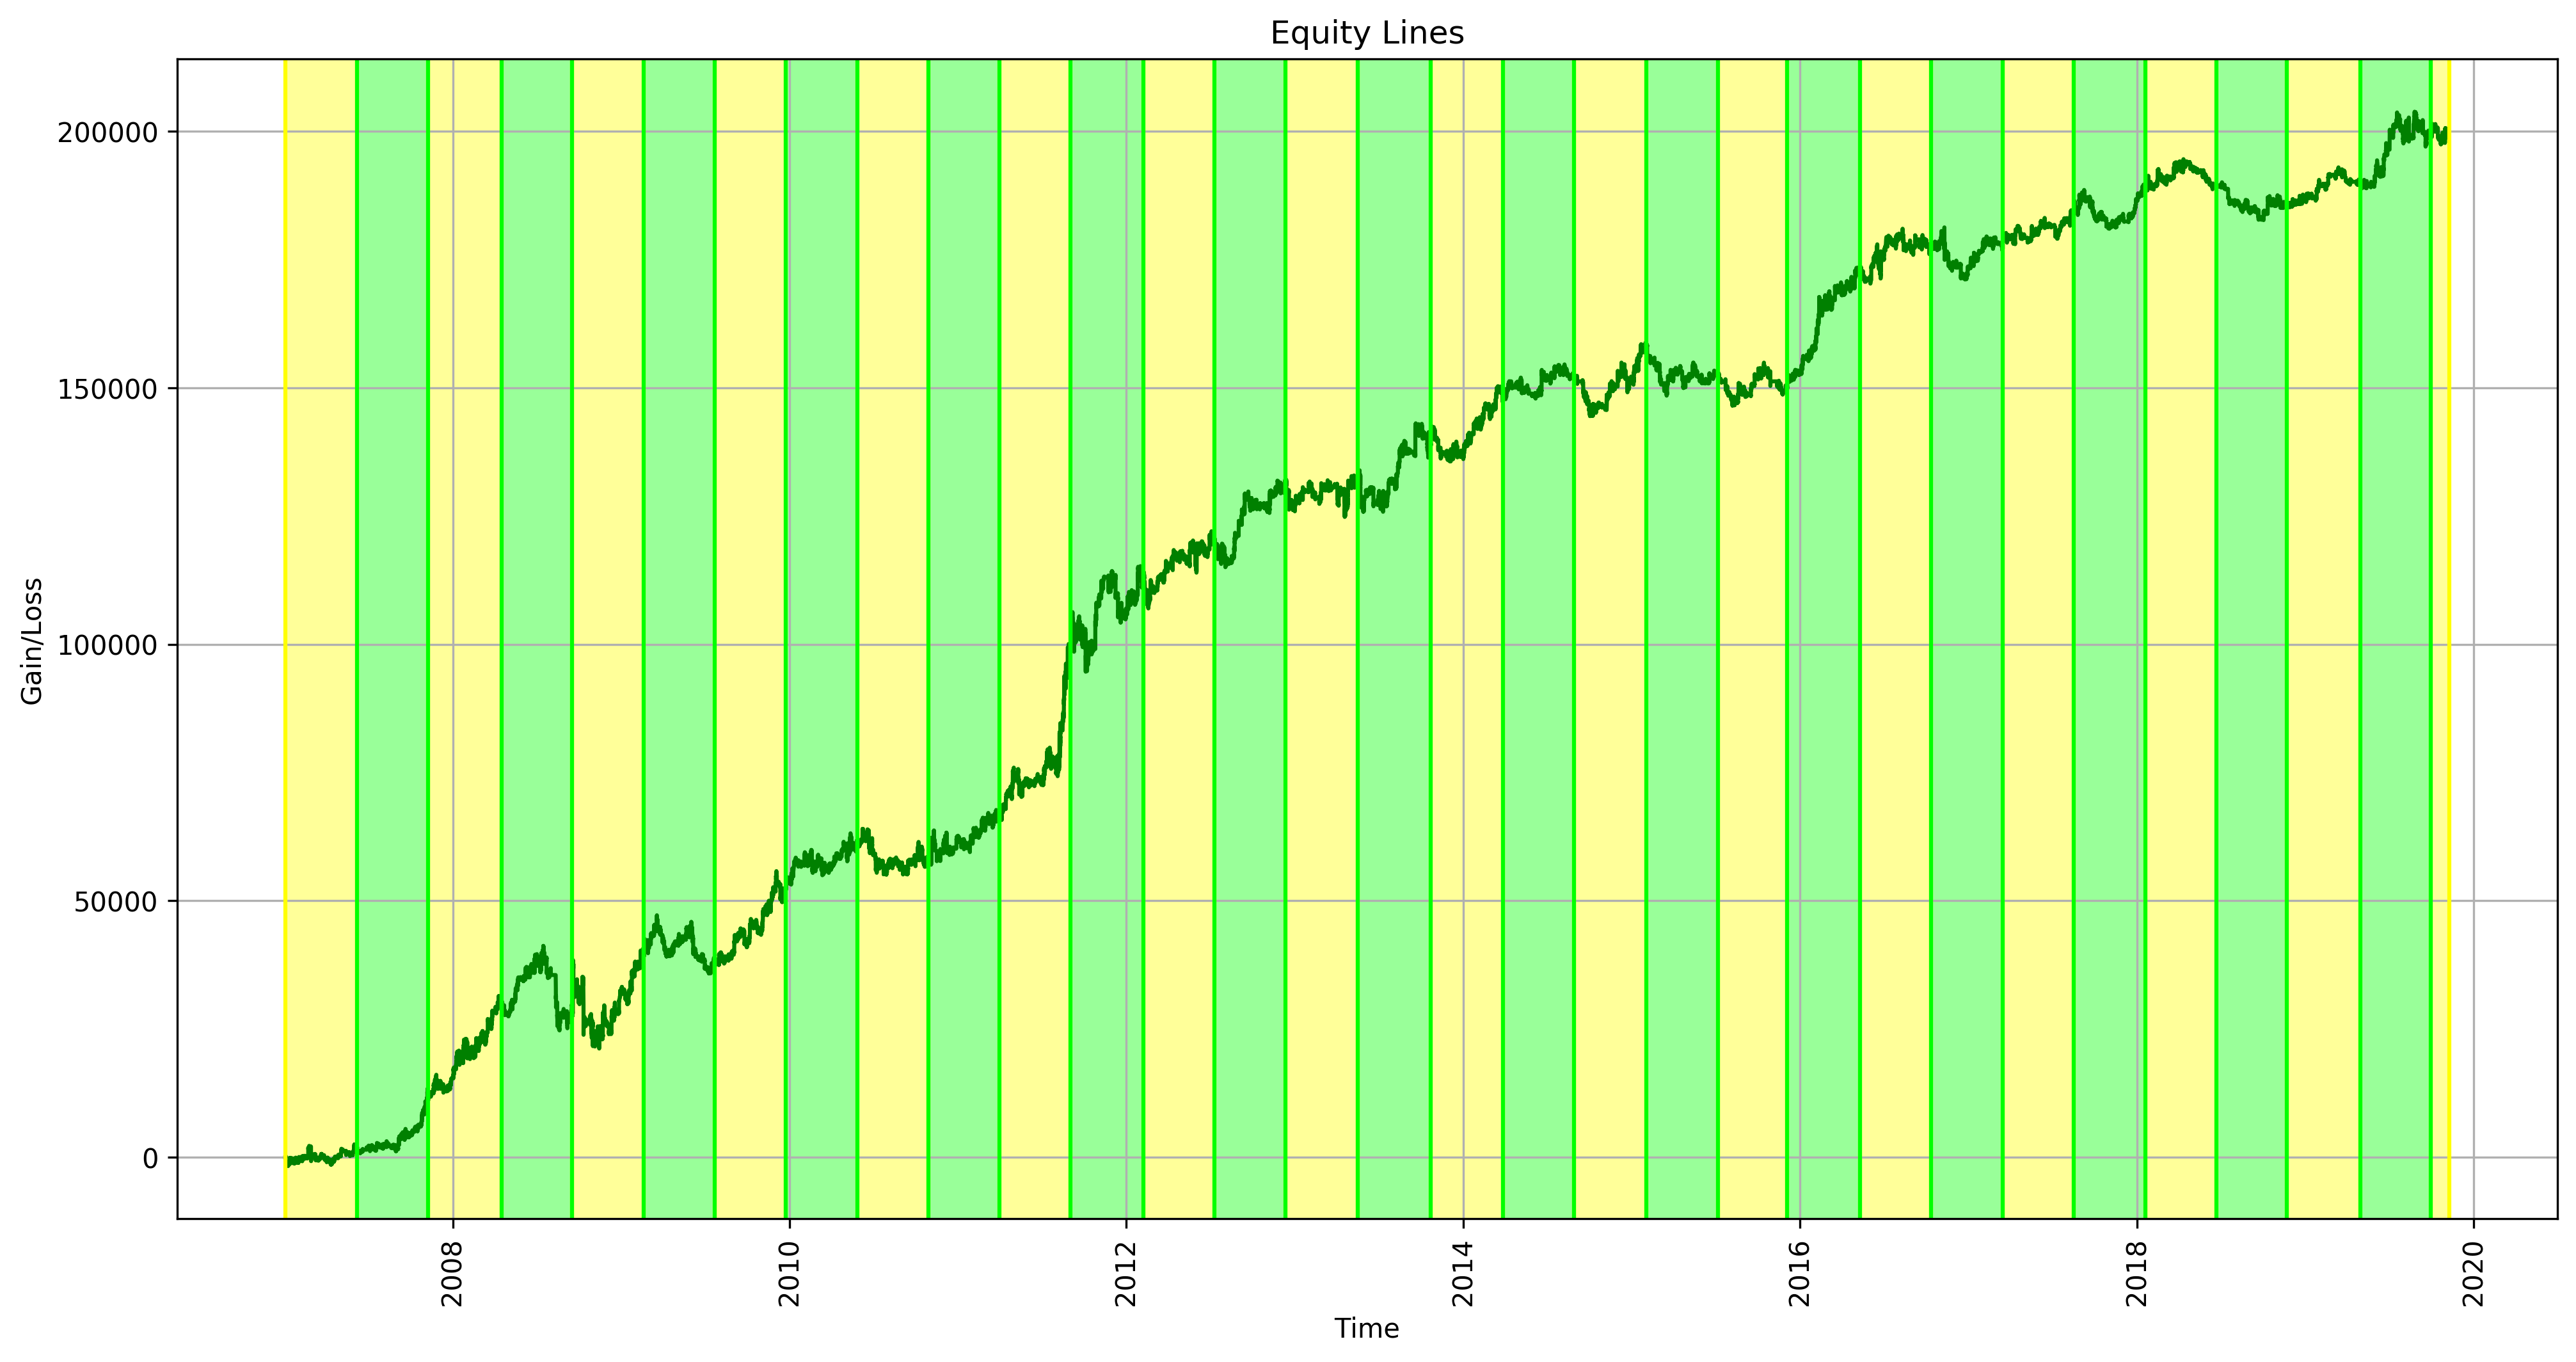

In [99]:
def plot_rectangles(start, step1, step2, color):
    while start < len(dataset):
        stop = start + step1
        if start <= len(dataset):
            start_parsed = dataset.index[start]
        else:
            start_parsed = dataset.index[len(dataset) - 1]
        if stop <= len(dataset):
            end_parsed = dataset.index[stop]
        else:
            end_parsed = dataset.index[len(dataset) - 1]
        print(start,start_parsed, stop, end_parsed)
        plt.axvline(x=start_parsed, color=color)
        plt.axvline(x=end_parsed, color=color)
        plt.axvspan(start_parsed, end_parsed, facecolor=color, alpha=0.4)
        start += step1 + step2

def plot_periods(step_IS,step_OOS):
    
    from pandas.plotting import register_matplotlib_converters
    
    plt.figure(figsize=(16, 8), dpi=300)
    plt.plot(trading_system.open_equity, color='green')

    # Generazione rettangoli In Sample
    print("In Sample:")
    plot_rectangles(0, step_IS, step_OOS, "yellow")
    print("")

    # Generazione rettangoli Out of Sample
    print("Out of Sample:")
    plot_rectangles(step_IS, step_OOS, step_IS, "lime")
    plt.xlabel("Time")
    plt.ylabel("Gain/Loss")
    plt.title("Equity Lines")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.show()

plot_periods(10000,10000)

Performance Report - by Gandalf Project R&D

Profit:                   200370.0
Operations:               2014
Average Trade:            99.49

Profit Factor:            1.33
Gross Profit:             808690.0
Gross Loss:               -608320.0

Percent Winning Trades:   53.87
Percent Losing Trades:    46.13
Reward Risk Ratio:        1.14

Max Gain:                 8780.0  in date  2008-09-17 22:00:00
Average Gain:             745.34
Max Loss:                 -7010.0  in date  2008-10-12 22:00:00
Average Loss:             -661.22

Avg Open Draw Down:       -3877.21
Max Open Draw Down:       -20020.0

Avg Closed Draw Down:     -3645.59
Max Closed Draw Down:     -18290.0

Avg Delay Between Peaks:  347.51
Max Delay Between Peaks:  28115


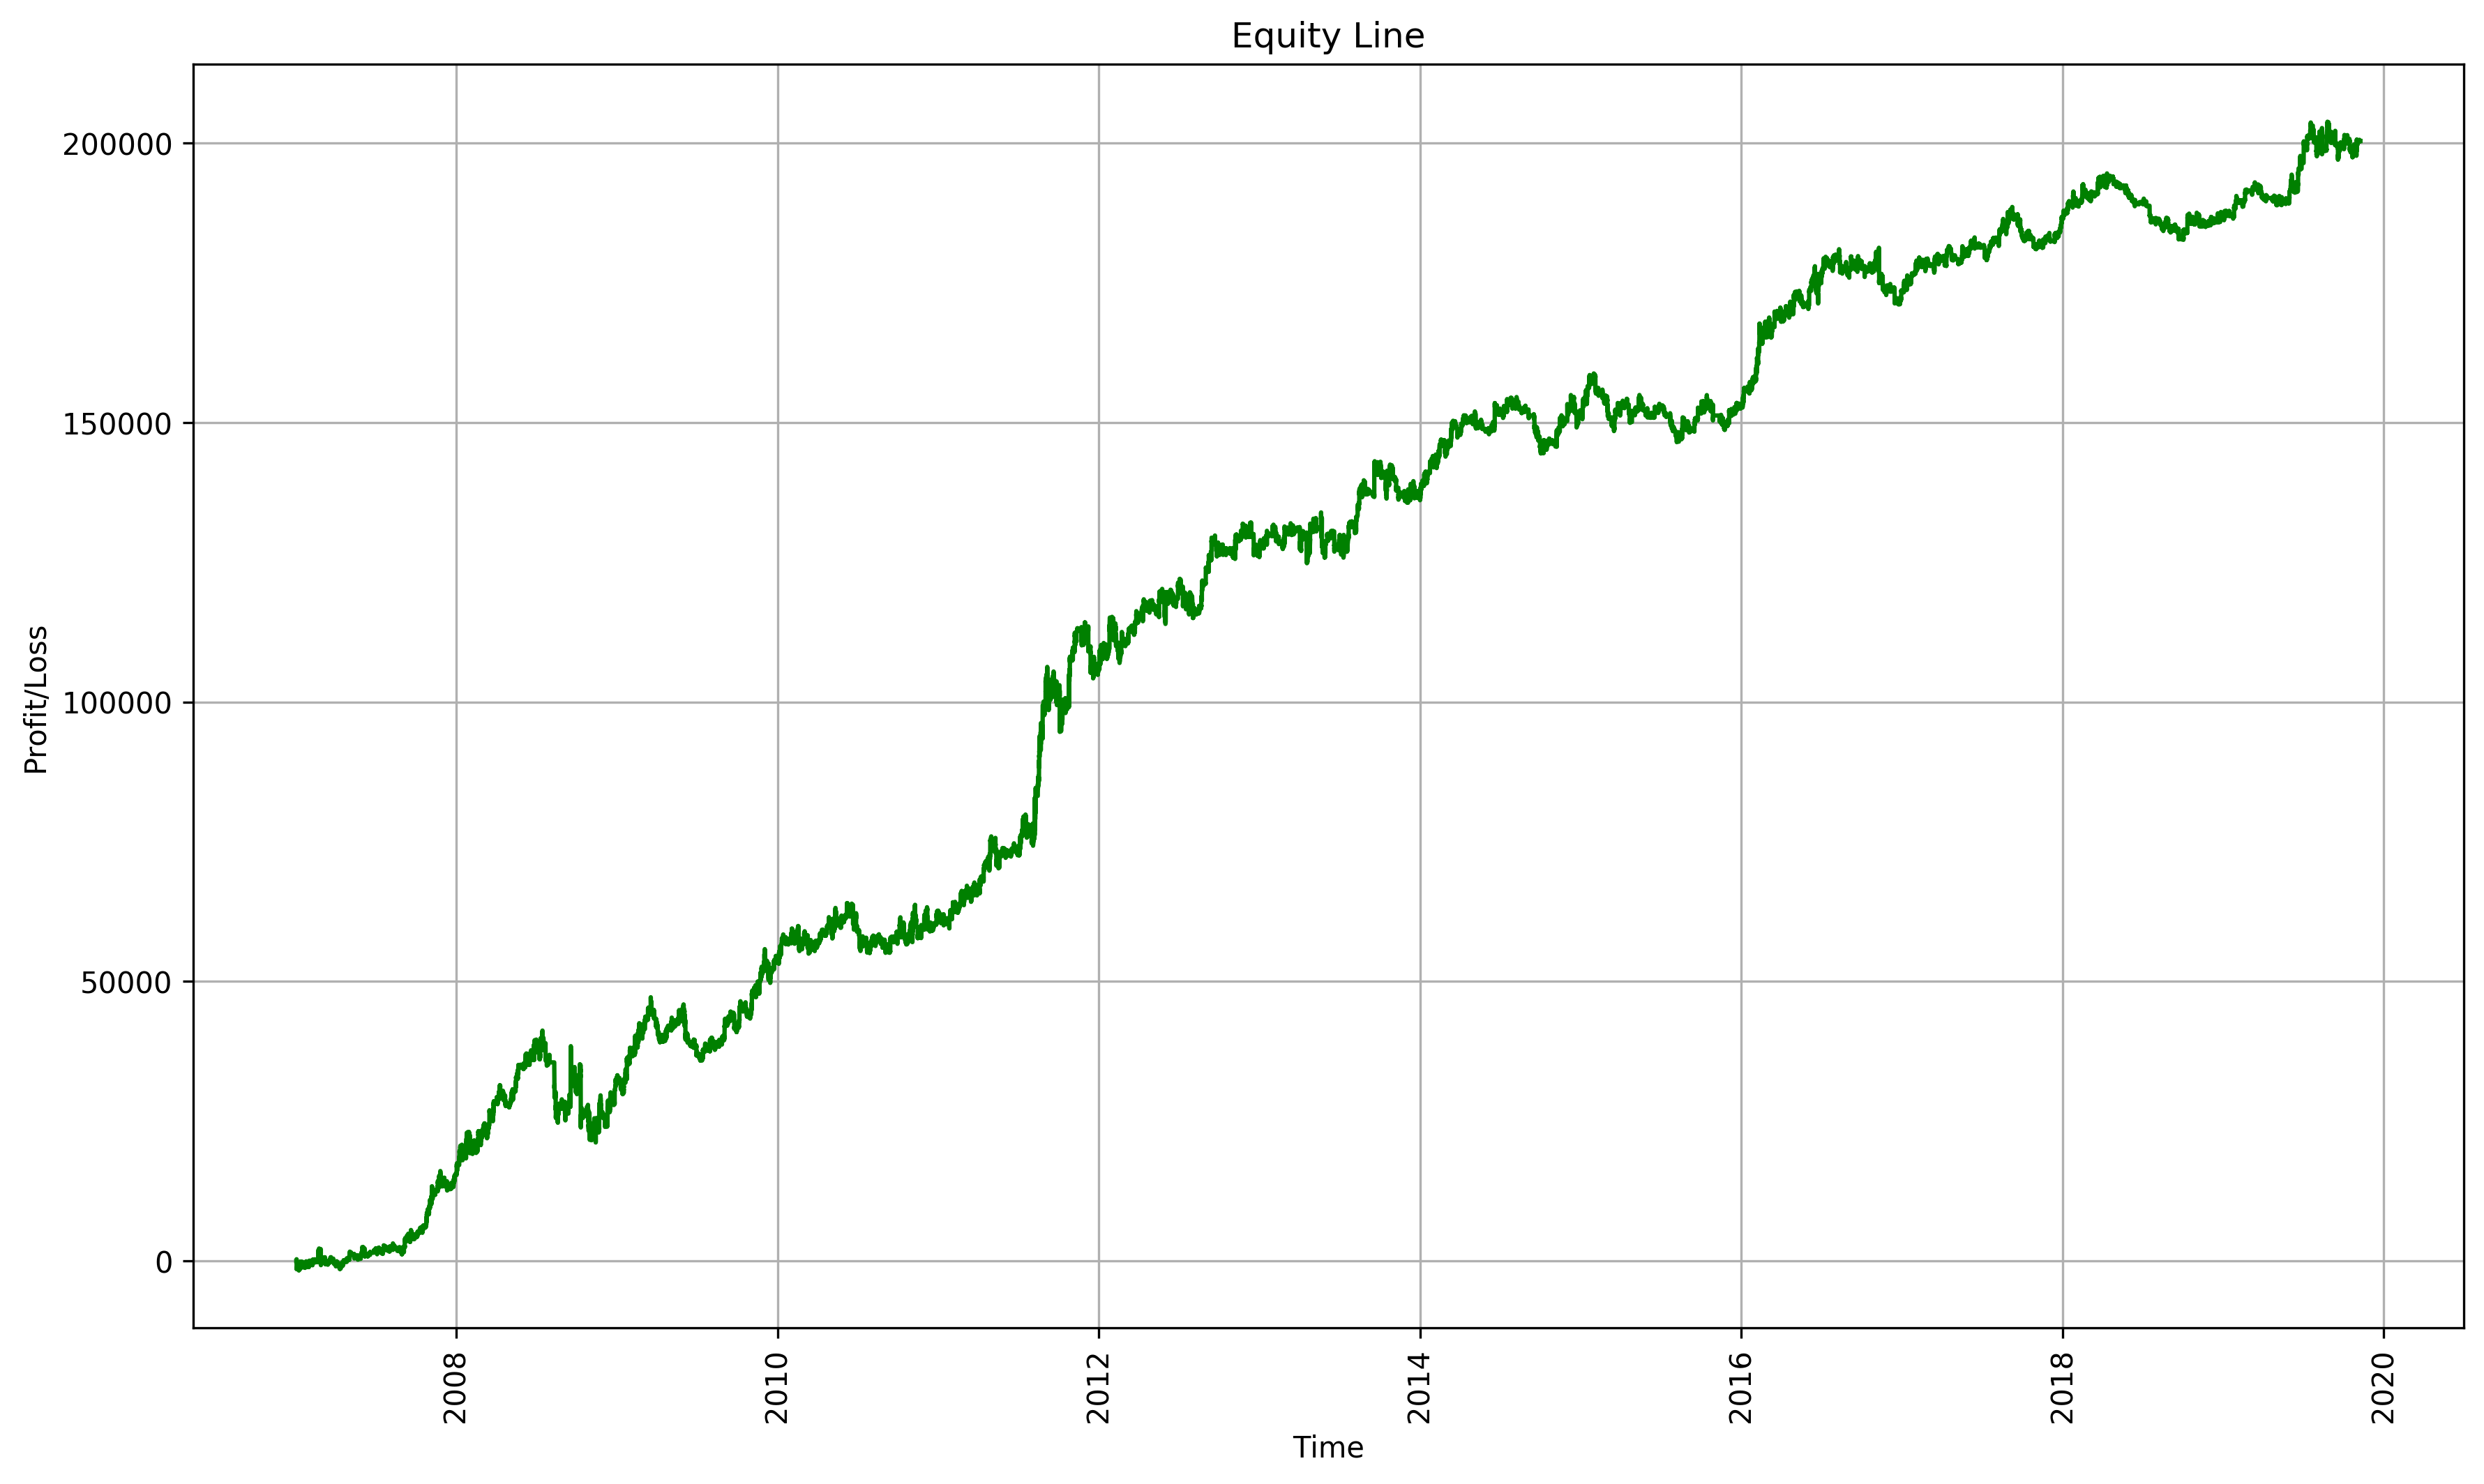

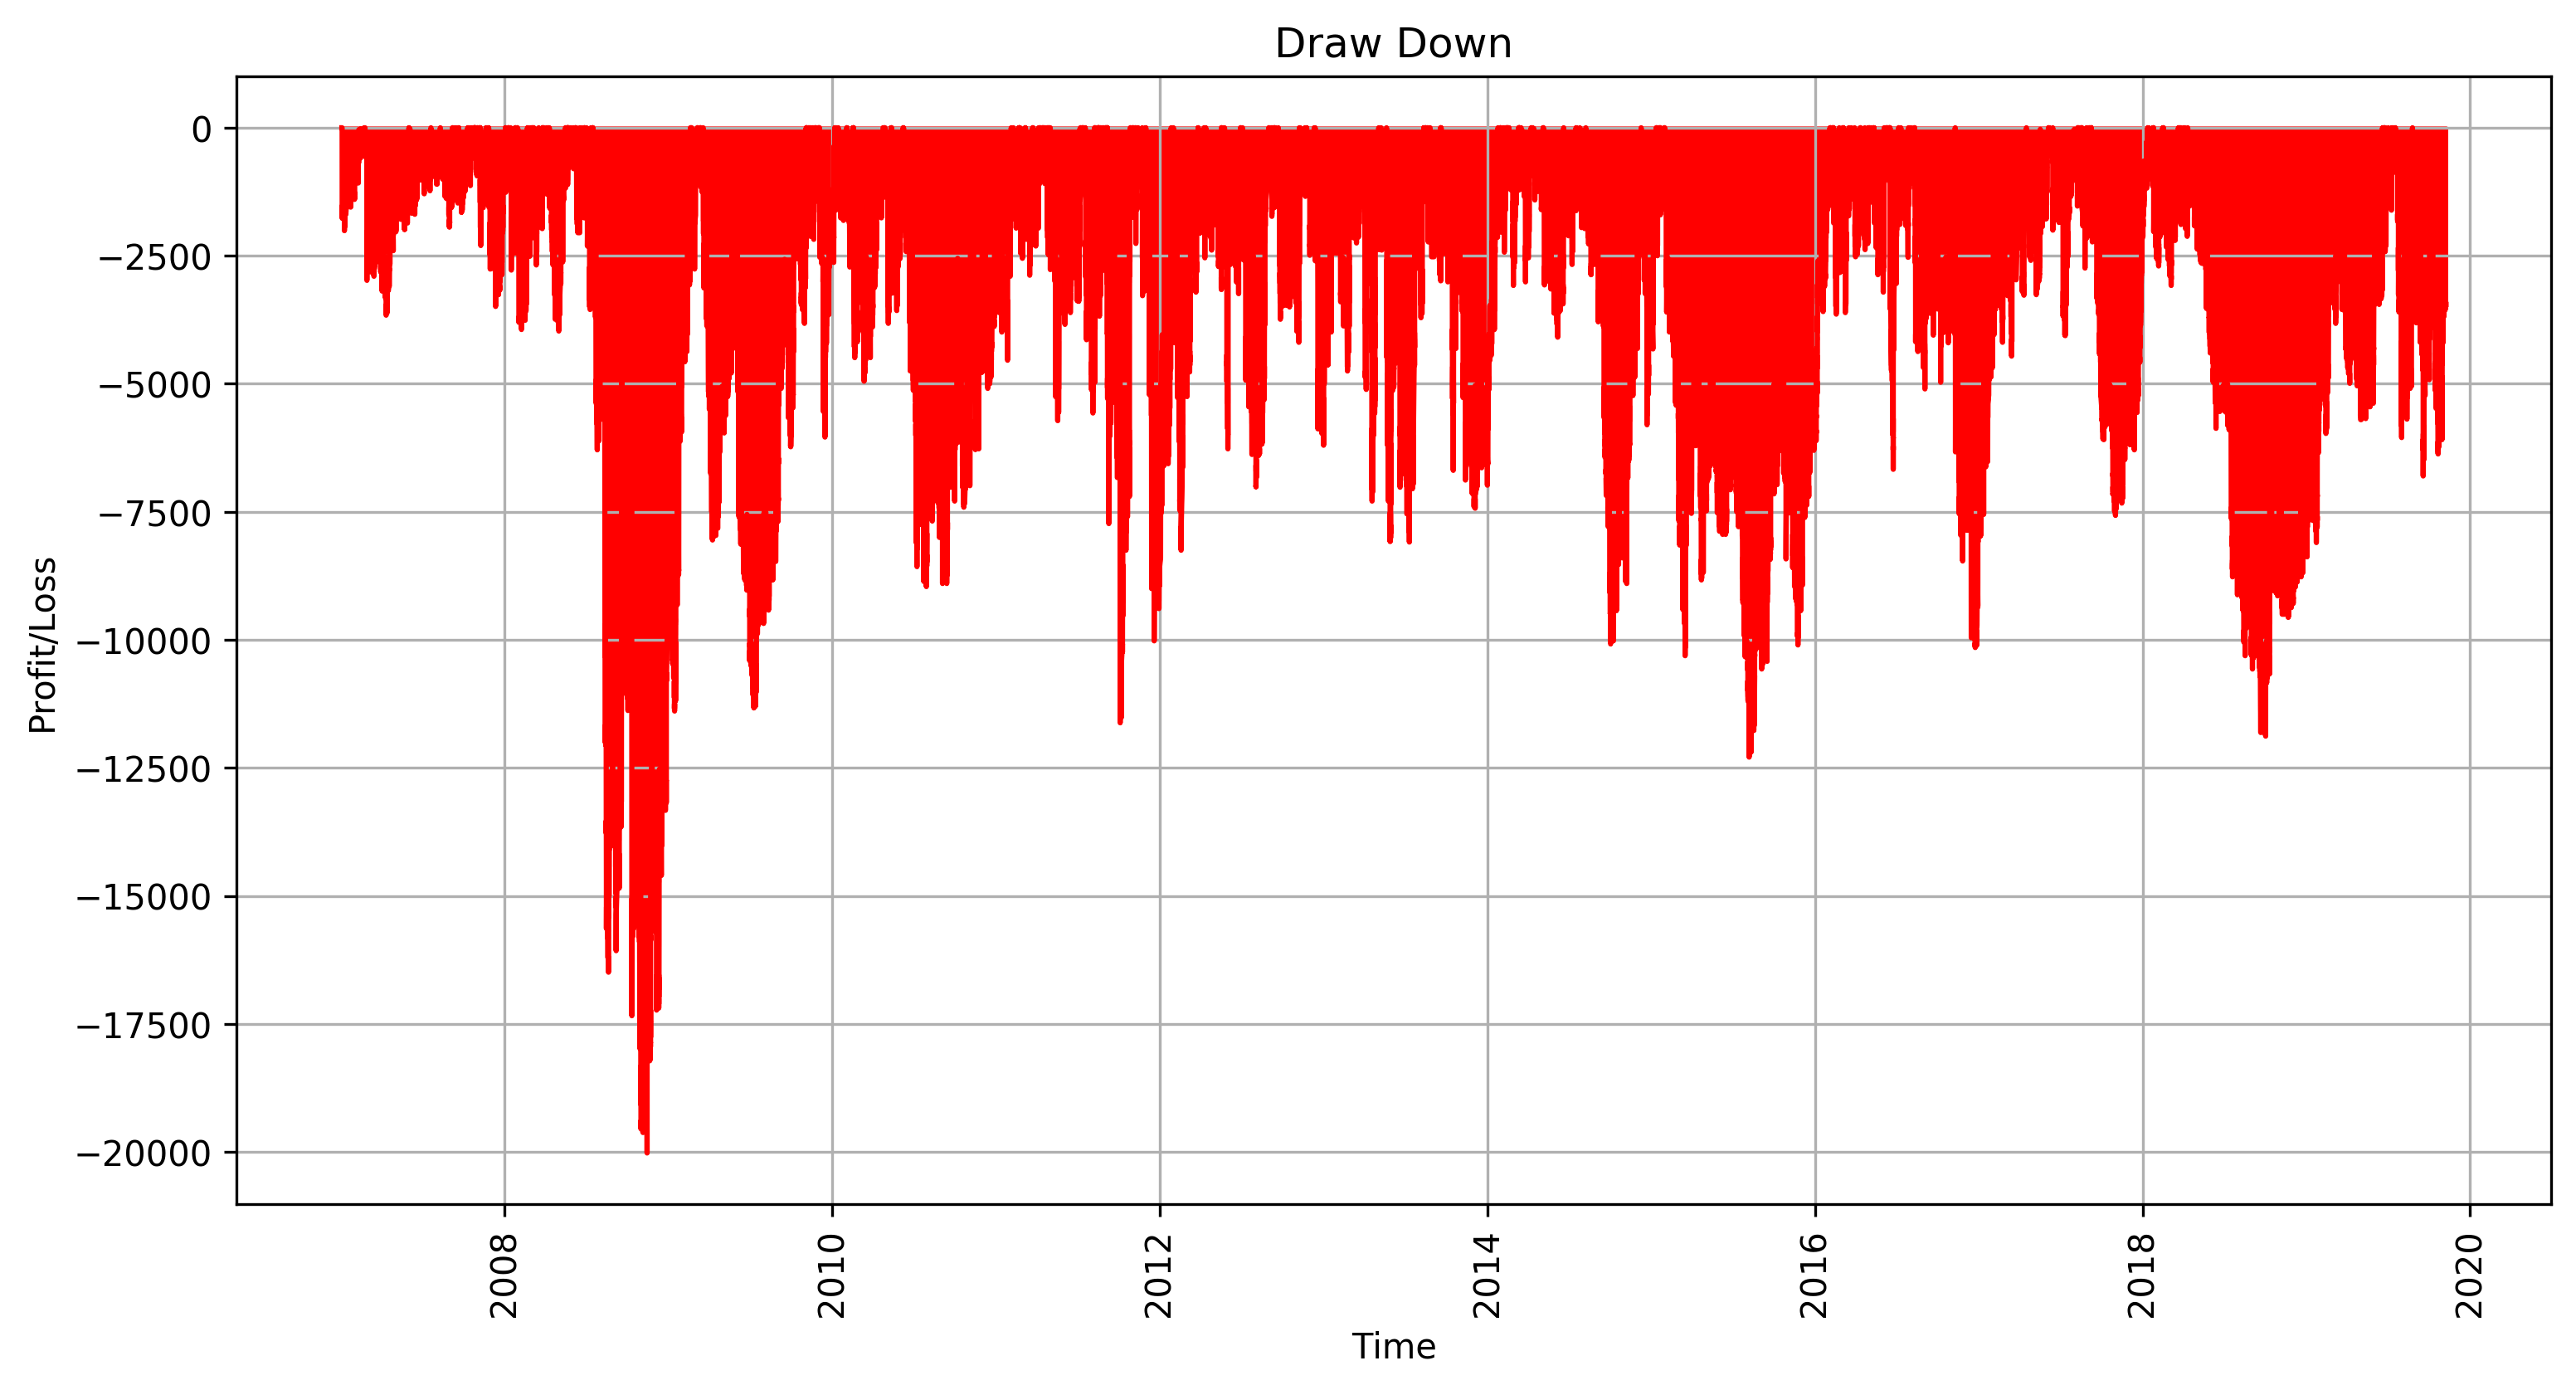

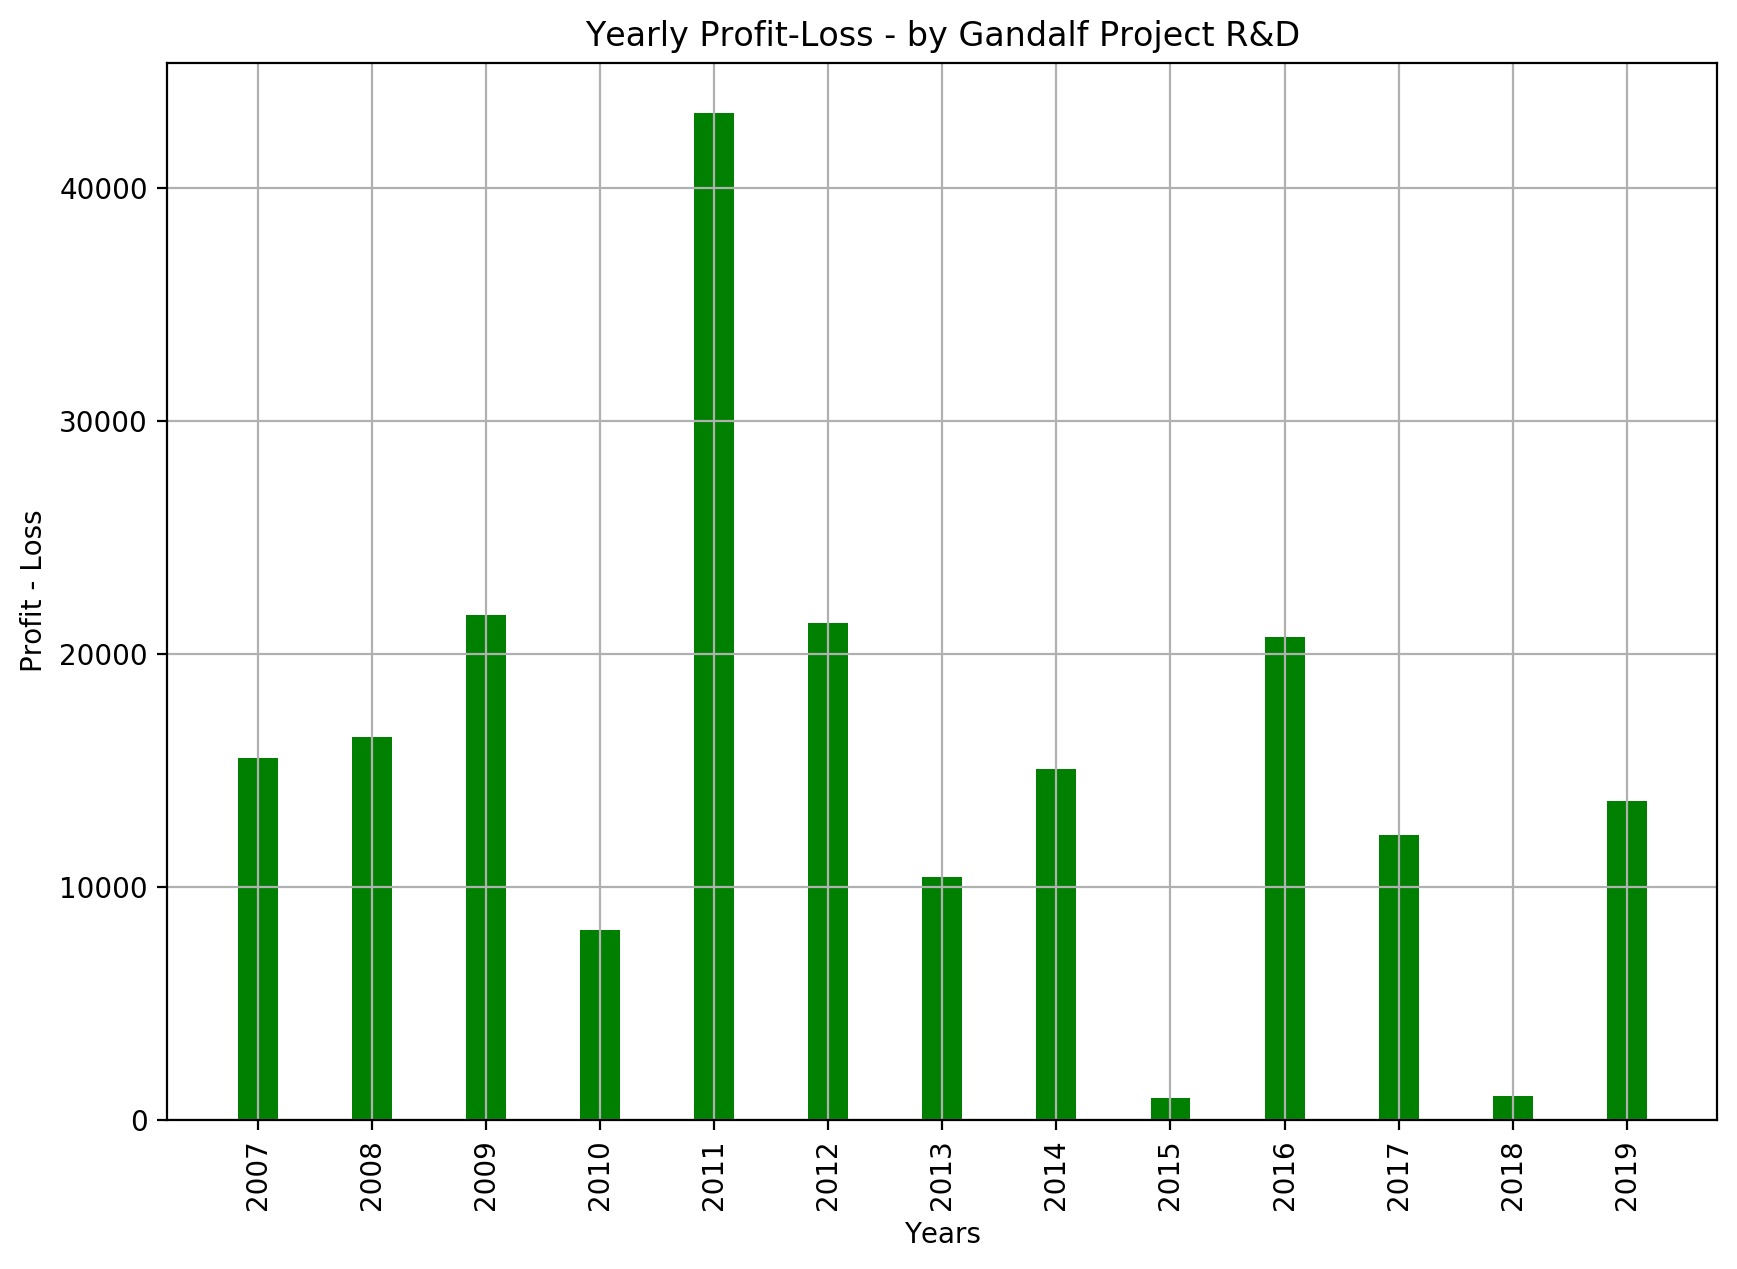

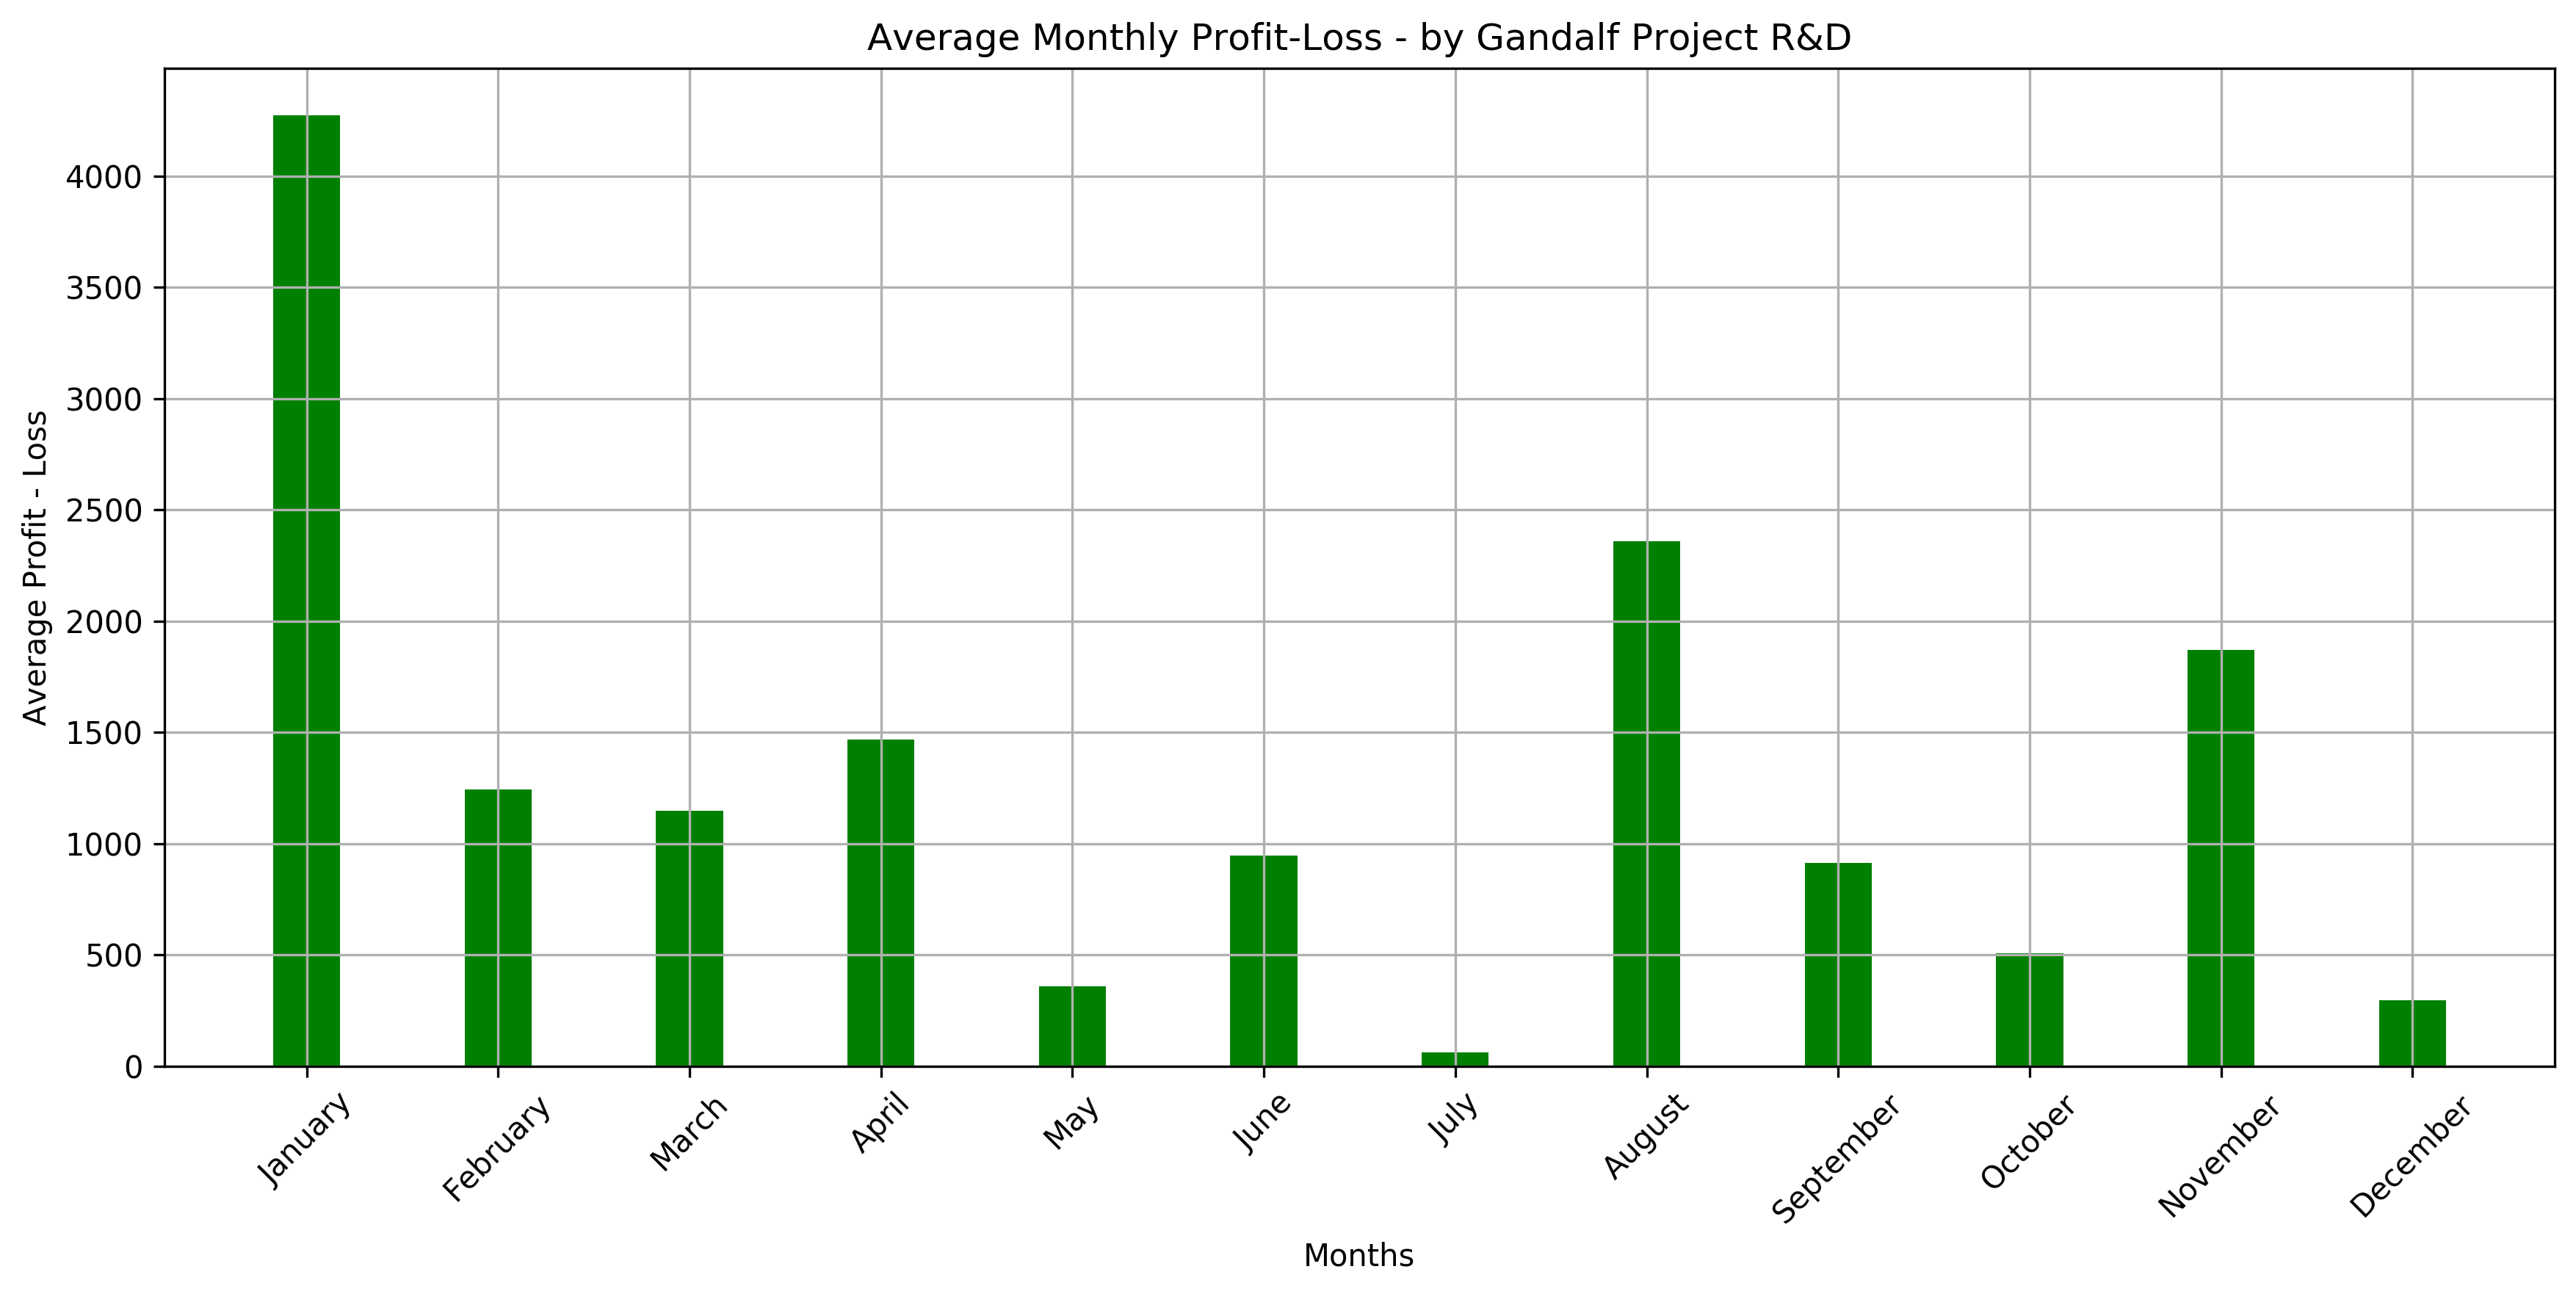

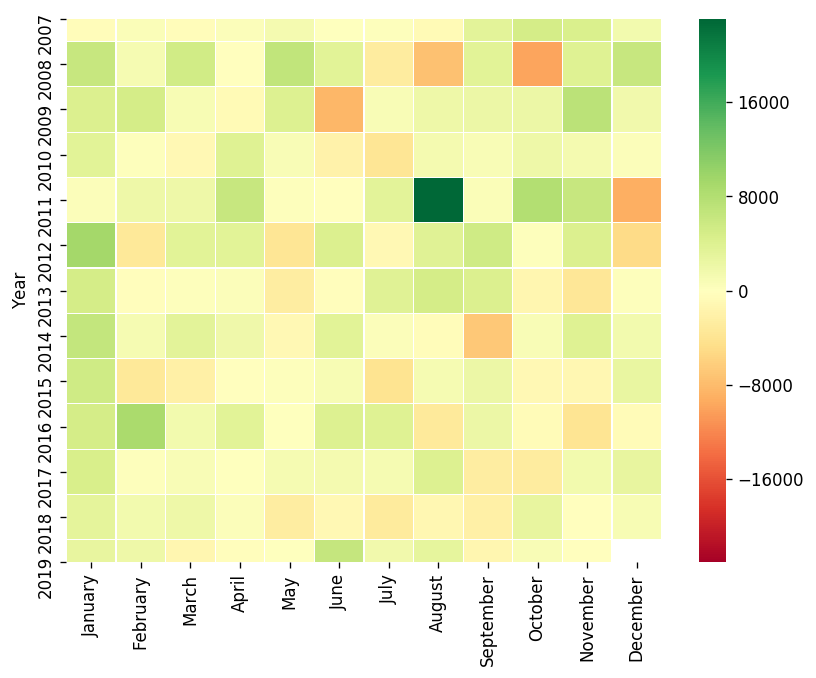

In [16]:
operations = trading_system.operations.dropna()

if operations.count() > 0:
    performance_report(trading_system, operations,
                       trading_system.closed_equity, trading_system.open_equity)
else: 
    print("Nessuna operazione registrata!")